# 1.2 ROT with Sinkhorn

The goal of this notebook is to manually implement the Sinkhorn algorithm to solve the regularized OT problem on a toy dataset.

## ROT Implementation between X points and Y points in $R^2$

Hyperparameters :
*   n number of X elements
*   m number of Y elements
*   seedX : a number to fix the random seed to generate X , or None to not use a seed
*   seedY : a number to fix the random seed to generate Y, or None to not use a seed

## Imports

In [ ]:
#Maths
import numpy as np
import math
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
#data handling
import pandas as pd
#Optim
from scipy import optimize

## Hyperparameters

In [ ]:
n = 10
m = 15
seedX = None
seedY = None

## Preprocessing

### Data and plotting

In [ ]:
# Generate n and m points to create X and Y
if seedX is not None : 
    np.random.seed(int(seedX))

X = np.random.rand(n,2)

if seedY is not None : 
    np.random.seed(int(seedY))
Y = np.random.rand(m,2)

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

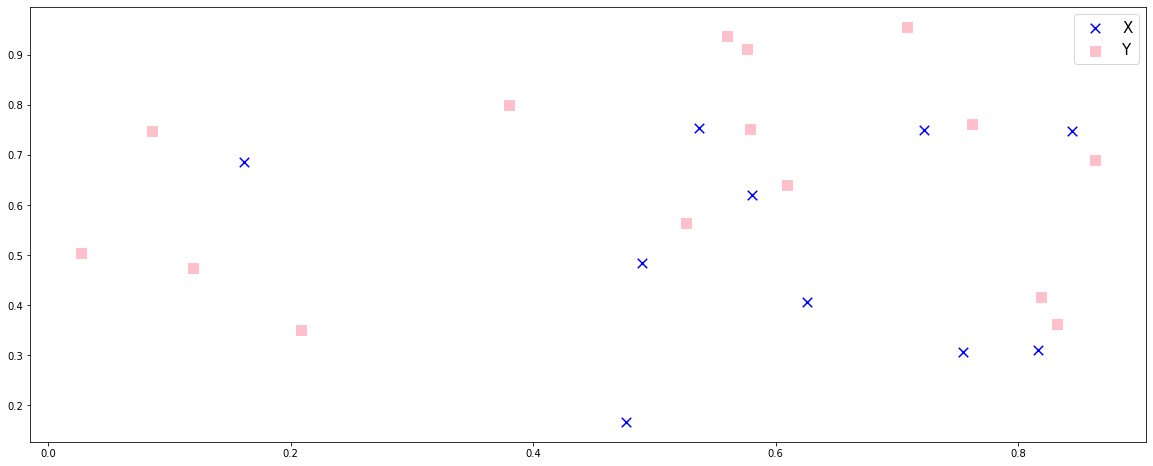

In [ ]:
fig = plt.figure(figsize = (20, 8))

plt.scatter(X[0],X[1], color='blue', s = 90, marker='x', label='X')
plt.scatter(Y[0],Y[1], color='pink', s = 90, marker='s', label = 'Y')

plt.legend(fontsize=15)
fig.show()

### Functions Definition

In [ ]:
# Returns the R2 norm between 2 points
def norm(xi, yi):
    return math.sqrt( (xi[0] - yi[0])**2 + (xi[1] - yi[1])**2 )

In [ ]:
# Returns the Cost Matrix to link X to Y
def costM(X, Y):
    n = len(X[0])
    m = len(Y[0])
    M = np.zeros((n, m))
    for i in range(n):
      for j in range(m):
        M[i][j] = norm(X.iloc[i], Y.iloc[j])
    return M

In [ ]:
# Returns the matrix of constraints such that Constraints * Transfer needs to be equal to [1/n , ..., 1/m]
# It's a matrix of shape (n + m, n*m) , that works on the flattened version of the Transfer matrix
def constraint_matrix(n, m):
    Constraints = np.zeros((n+m, n*m))
    for i in range(n):
        for j in range(m):
            Constraints[i][i*m+j] = 1
            Constraints[n+j][j+i*m] = 1
    return Constraints

## Optimization

### Matrices definition

In [ ]:
# We initialize the Transfer Matrix with the uniform matrix
Cost = costM(X, Y)

##Regularized OT


###Sinkhorn's Algorithm definition

Sinkhorn algorithm calculates solution of poblem with entropic regulation:

$$\mathbf{P\varepsilon} =\min _{\mathbf{P} \in \mathbf{U}(\mathbf{a}, \mathbf{b})}\langle\mathbf{P}, \mathbf{C}\rangle-\varepsilon \mathbf{H}(\mathbf{P}) \quad with \quad \mathbf{H}(\mathbf{P}) \stackrel{\text { def. }}{=}-\sum_{i, j} \mathbf{P}_{i, j}\left(\log \left(\mathbf{P}_{i, j}\right)-1\right)$$

In [ ]:
#def of Sinkhorn algo
def Sinkhorn(C,a,b,epsilon,niter = 500):
    K=np.exp(-C/epsilon)
    v=np.ones(b.size)
    for it in range(niter):
        u=a/(np.dot(K,v))
        v=b/(np.dot(K.T,u))
    P = np.dot(np.diag(u),np.dot(K,np.diag(v)))
    return P

In [ ]:
#Parameters

a=np.ones(n)*1/n #constraint vector a
b=np.ones(m)*1/m #constraint vector b
epsilon=0.15 #Wheight coeff of entropic regularization
n_iter=1000

###Computations

In [ ]:
P_sink = Sinkhorn(Cost,a,b,epsilon,n_iter) #compute the transport plan P from the Sinkhorn algorithm

# We normalize based on the max value to use the transparency to visualize the weights of each connection with alpha
maxValue_sink = np.amax(P_sink)
alphas_sink = P_sink * (1/maxValue_sink)

# Check Equality constraints (!!for gepsilon too small the constraint on a is not respected!!)
print(np.around(np.dot(P_sink,np.ones(m)),5)==np.around(a,5))
print(np.around(np.dot(P_sink.T,np.ones(n)),5)==np.around(b,5))

#Calculates the total distance
(P_sink*Cost).sum()

[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


0.28609370013879815

Now plotting the results of the computed transport plan P from Sinkhorn algorithm. The darkness of the links between points is proportionnal to the value of the exchanged amount of mass.

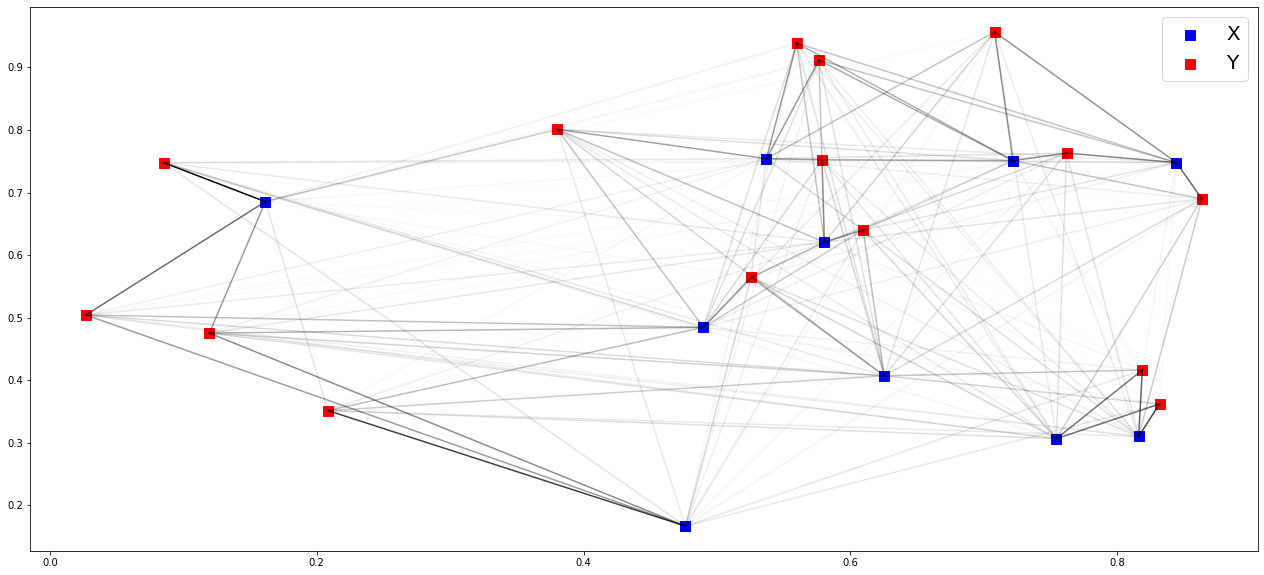

In [ ]:
# Plot the results
fig = plt.figure( figsize = (22, 10))
plt.scatter(X[0],X[1], color='blue', s = 90, marker='s', label='X')
plt.scatter(Y[0],Y[1], color='red', s = 90, marker='s', label = 'Y')
for i in range(n):
    for j in range(m):
        plt.plot ( [X[0][i], Y[0][j]], [X[1][i], Y[1][j]], linestyle = '-', alpha = alphas_sink[i][j], color='black')
plt.legend(fontsize=20)
fig.show()

Show the influence of entropie (epsilon factor) on the transport plan solution P using Heatmaps 

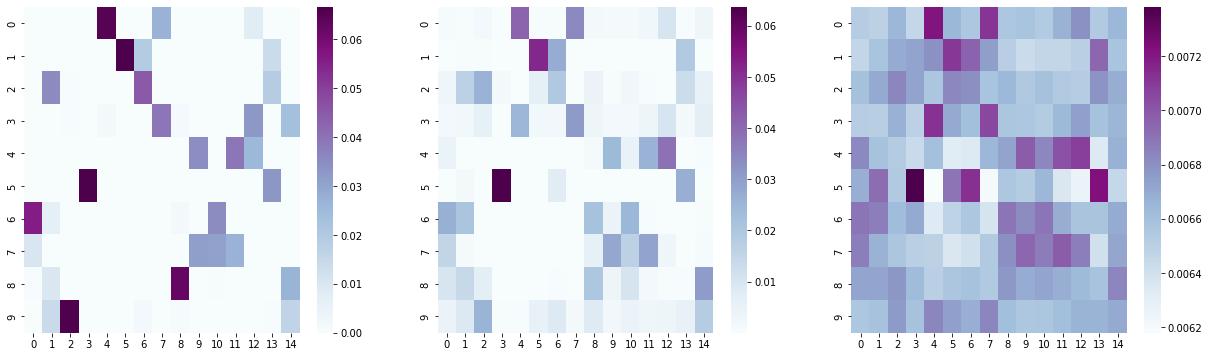

In [ ]:
epsilons=[0.005,0.05,5]
Ps=[]

for epsilon in epsilons:
  Ps.append(Sinkhorn(Cost,a,b,epsilon,n_iter)) #compute the transport plan P from the Sinkhorn algorithm

#plot
fig, axs = plt.subplots(1,len(epsilons),figsize = (21, 6))
for i in range(len(axs)):
    sns.heatmap(Ps[i], cmap="BuPu", ax=axs[i])
plt.show()